## Probability Calibration Curve

In this notebook, we will plot Probability calibration curves for logistic regression predictions made from balanced and imbalanced datasets.

Probability calibration curves allow us to visualize if the probability is calibrated.

Remember that logistic regression tends to return balanced probabilities.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# to create artificial data
from sklearn.datasets import make_classification

# to train a model and plot the calibration curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve

import warnings
warnings.filterwarnings("ignore")

## Function to create toy data

In [2]:
def create_dataset(weights):

    # returns arrays
    X, y = make_classification(
        n_samples=10000,
        n_features=10,
        n_redundant=0,
        n_clusters_per_class=1,
        weights=[weights],  # to balance (or not) the classes
        class_sep=1,  # how separated the classes are
        random_state=1)

    # trasform arrays into pandas df and series
    X = pd.DataFrame(X)
    y = pd.Series(y)
    
    return X, y

## Create a balanced dataset

The 2 classes are fairly well separated for the demonstration.

In [3]:
X, y = create_dataset(weights=0.5)

# show dataset
X.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.658803,0.829669,-0.144299,1.023428,-1.202420,0.143194,1.442737,0.105750,0.639316,-0.015008
1,-0.257548,2.483056,0.379567,-2.254821,-0.072324,1.609488,-0.660558,0.463669,-0.244913,0.311547
2,-0.308108,1.457985,0.369361,1.295003,-1.813459,0.200404,0.199826,-0.401978,-0.365098,0.533825
3,-0.023793,1.319102,-1.614718,-0.397581,-0.092439,0.789002,-0.261107,-0.750842,1.650654,1.747664
4,1.078281,1.551971,-1.647722,2.509523,0.314624,-1.146409,-1.244661,-0.469266,1.982250,0.422053


In [4]:
# number of observations per class

y.value_counts()

1    5000
0    5000
dtype: int64

In [5]:
# balancing ratio

y.value_counts() / len(y)

1    0.5
0    0.5
dtype: float64

### Separate into train and test sets

In [6]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    X,  
    y,  
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((7000, 10), (3000, 10))

In [7]:
# balancing ratio: train set

y_train.value_counts() / len(X_train)

1    0.5
0    0.5
dtype: float64

In [8]:
# number of observations per class

y_train.value_counts()

1    3500
0    3500
dtype: int64

You can go ahead and check the balancing ratio for the test set, should be similar.

### Train Logistic Regression

In [9]:
# Logistic Regression on balanced dataset

logit = LogisticRegression(
    penalty='l2',
    solver='newton-cg',
    C=1,
    random_state=0,
    max_iter=100,
).fit(X_train, y_train)

# score the test set
probs = logit.predict_proba(X_test)[:, 1]

## Calibration Curve

https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html#sklearn.calibration.calibration_curve

- Sorts the probability values into bins
- Determines the true positive fraction in those bins

In [10]:
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, probs, n_bins=10, strategy='uniform')

len(mean_predicted_value), len(fraction_of_positives)

(10, 10)

In [11]:
# mean probability of each interval / bin

mean_predicted_value

array([0.03588248, 0.14189299, 0.24567388, 0.35046407, 0.45454455,
       0.54483823, 0.65526564, 0.75087511, 0.85704375, 0.97653893])

In [12]:
# fraction of observations of the minority class
# in each interval of probability

fraction_of_positives

array([0.03699422, 0.13919414, 0.19565217, 0.30833333, 0.44036697,
       0.45348837, 0.67      , 0.79166667, 0.88541667, 0.98633018])

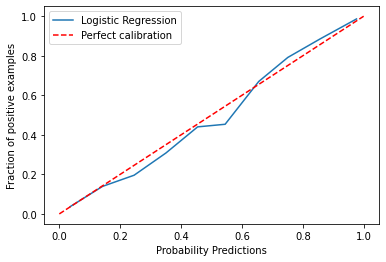

In [13]:
# plot calibration curve
plt.plot(mean_predicted_value, fraction_of_positives, label='Logistic Regression')

# plot perfect calibration line
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10),
         linestyle='--', color='red', label='Perfect calibration')

# add labels and legends
plt.xlabel('Probability Predictions')
plt.ylabel('Fraction of positive examples')
plt.legend(loc='upper left')
plt.show()

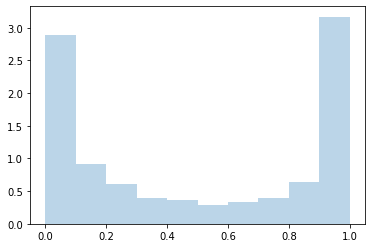

In [14]:
# plot number of observation per prediction interval

plt.hist(probs, range=(0, 1), bins=10, density=True, stacked=True, alpha=0.3)
plt.show()

In [15]:
# bring all together

def plot_calibration_curve(y_true, probs, bins, strategy):

    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, probs, n_bins=bins, strategy=strategy)
    
    max_val = max(mean_predicted_value)
    
    plt.figure(figsize=(8,10))
    plt.subplot(2, 1, 1)
    plt.plot(mean_predicted_value, fraction_of_positives, label='Logistic Regression')
    plt.plot(np.linspace(0, max_val, bins), np.linspace(0, max_val, bins),
         linestyle='--', color='red', label='Perfect calibration')
    
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of positive examples')
    plt.title('Calibration Curve')
    plt.legend(loc='upper left')


    plt.subplot(2, 1, 2)
    plt.hist(probs, range=(0, 1), bins=bins, density=True, stacked=True, alpha=0.3)
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of examples')
    plt.title('Density')
    plt.show()

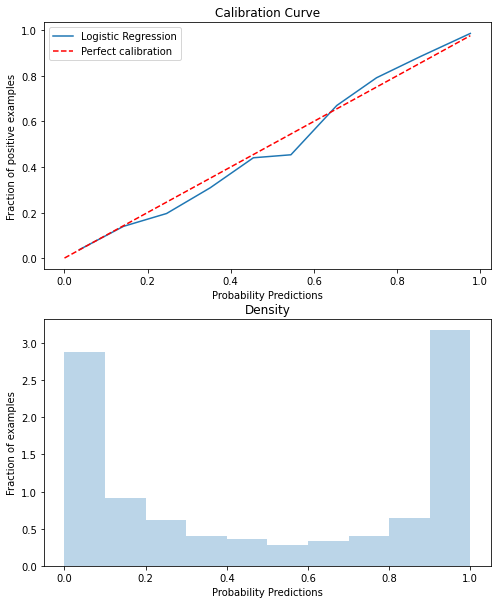

In [16]:
plot_calibration_curve(y_test, probs, bins=10, strategy='uniform')

### Change number of probability bins

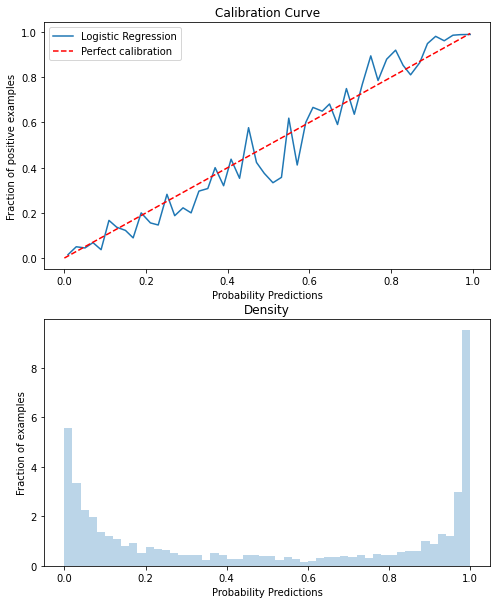

In [17]:
plot_calibration_curve(y_test, probs, bins=50, strategy='uniform')

The less observations we have per interval, the harder to obtain a reliable probability vs positive fraction estimate. This, the functions seems more noisy.

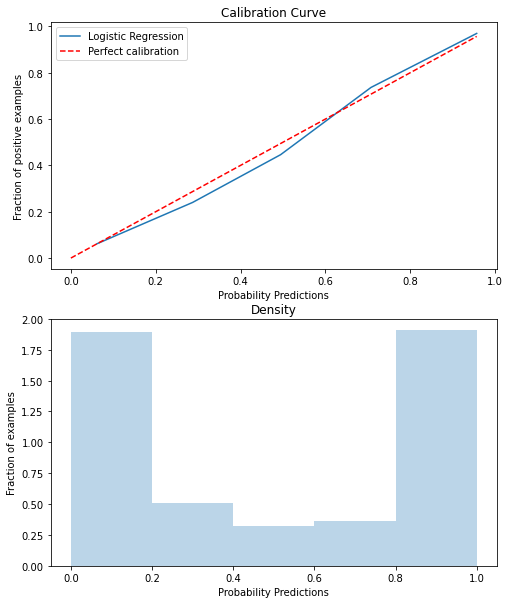

In [18]:
plot_calibration_curve(y_test, probs, bins=5, strategy='uniform')

**HOMEWORK 1**: Train another model, different from Logistic Regression and determine the calibration curve. Are probabilities calibrated?

## Imbalanced dataset

In [19]:
X, y = create_dataset(weights=0.9)

# number of observations per class
y.value_counts()

0    8954
1    1046
dtype: int64

In [20]:
# balancing ratio

y.value_counts() / len(y)

0    0.8954
1    0.1046
dtype: float64

### Separate train and test

In [21]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    X,  
    y,  
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((7000, 10), (3000, 10))

### Train Logistic Regression

In [22]:
# Logistic Regression on imbalanced dataset

logit = LogisticRegression(
    penalty='l2',
    solver='newton-cg',
    C=1,
    random_state=0,
    max_iter=100,
).fit(X_train, y_train)

# score the test set
probs = logit.predict_proba(X_test)[:, 1]

## Calibration Curve

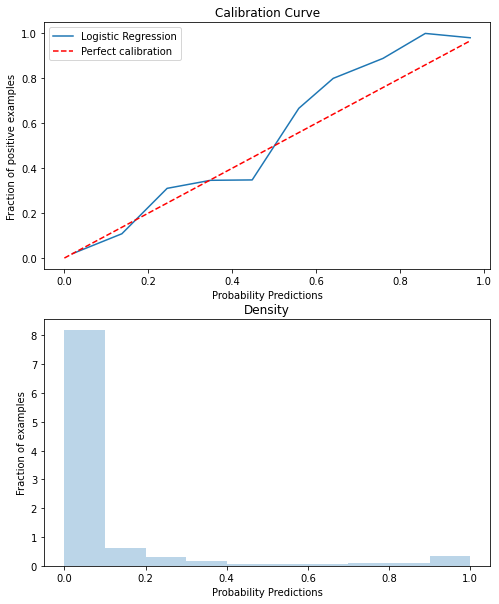

In [23]:
plot_calibration_curve(y_test, probs, bins=10, strategy='uniform')

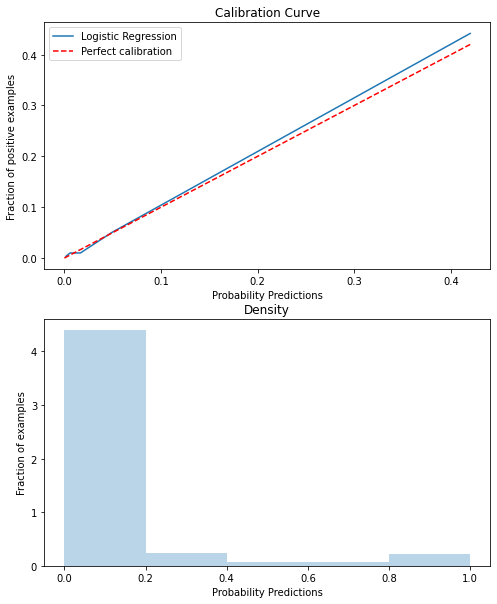

In [24]:
plot_calibration_curve(y_test, probs, bins=5, strategy='quantile')

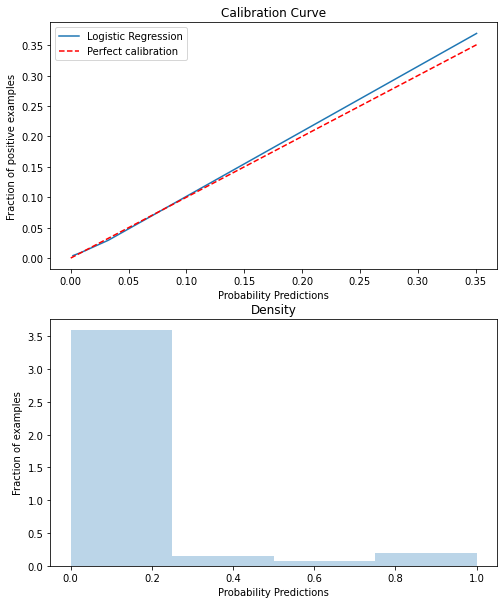

In [25]:
plot_calibration_curve(y_test, probs, bins=4, strategy='quantile')

The predictions do not seem to be balanced. Most likely it is because we do not have a sufficient number of observations of the positive class, to accurately determine the fraction of positives.

**HOMEWORK 2**: increase the number of observations in the dataset, and if you want as well, the balancing ratio, and observe the change in the calibration curve. What do you see?